# Import the necessary libraries

In [1]:
import sys
sys.path.append("../../Utils/")

In [2]:
from sklearn.externals import joblib
from scipy.sparse import csr_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, accuracy_score
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_predict
import utils
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

# Load the data

In [3]:
X_path = '/home/imad/Desktop/Yelp_vectorized_data/Gold/Restaurants_X.pkl'
y_path = '/home/imad/Desktop/Yelp_vectorized_data/Gold/Restaurants_y.pkl'
output_path = './Output/'

In [4]:
# Load a sparse matrix of the text (reviews)
X = joblib.load(X_path)
X.shape

(2827730, 953947)

In [5]:
# Load the labels (ratings)
y = joblib.load(y_path)
y.shape

(2827730,)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Re-label 0,1 stars as 0 / 4, 5 as 1 in the test dataset

In [7]:
for i in y_test.index:
    if y_test[i] == 1 or y_test[i] == 2:
        y_test[i] = 0
    elif y_test[i] == 4 or y_test[i] == 5:
        y_test[i] = 1

In [8]:
y_test.value_counts()

1.0    551362
0.0    175973
3.0    120984
Name: stars, dtype: int64

# Removing 3-star ratings from the training dataset

In [9]:
neutral_ratings_ids = list(np.where(y_train == 3)[0])
len(neutral_ratings_ids)

282296

In [10]:
X_train = utils.delete_from_csr(X_train, row_indices=neutral_ratings_ids)

In [11]:
X_train.shape

(1697115, 953947)

# Re-label 1, 2 as 0 / 4, 5 as 1 in the training dataset

In [12]:
y_train = np.delete(y_train.tolist(), neutral_ratings_ids)

In [13]:
for i in range(0, len(y_train)):
    if y_train[i] == 1 or y_train[i] == 2:
        y_train[i] = 0
    else:
        y_train[i] = 1

In [14]:
y_train.shape

(1697115,)

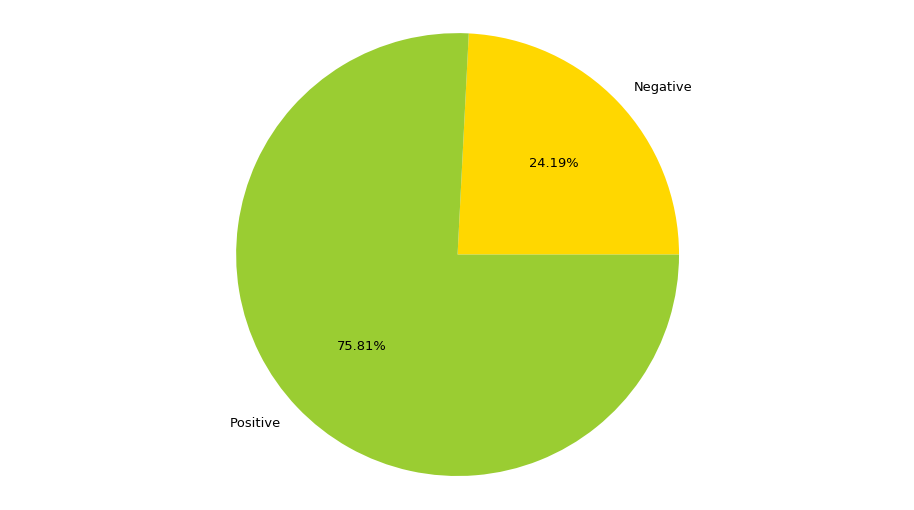

In [15]:
# Rating Distribution
values, counts = np.unique(y_train, return_counts=True)
colors = ['gold', 'yellowgreen']

# Plot
mpl.rcParams['font.size'] = 13.0
f = plt.figure()
f.set_size_inches(16,9)
plt.pie(counts, labels=['Negative', 'Positive'], colors=colors, autopct='%1.2f%%')
plt.axis('equal')
plt.show()
f.savefig(output_path + 'Distribution.pdf')

# Feature Selection

In [16]:
F_scores, P_values = f_classif(X_train, y_train)
print(F_scores)
print(P_values)

/home/imad/anaconda2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  UserWarning)
/home/imad/anaconda2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[       nan        nan        nan ... 0.31915871 3.13324002 3.13324002]
[       nan        nan        nan ... 0.57211374 0.07671132 0.07671132]


In [17]:
# Delete high P_values support the null Hypothesis H0
feat_to_delete = []
for i in range(0, len(P_values)):
    if(P_values[i] > 0.05):
        feat_to_delete.append(i)

In [18]:
X_train = utils.delete_from_csr(X_train, col_indices=feat_to_delete)
X_train

<1697115x333128 sparse matrix of type '<type 'numpy.int64'>'
	with 76410178 stored elements in Compressed Sparse Row format>

In [19]:
X_test = utils.delete_from_csr(X_test, col_indices=feat_to_delete)
X_test

<848319x333128 sparse matrix of type '<type 'numpy.int64'>'
	with 39313617 stored elements in Compressed Sparse Row format>

# MNB Smoothing-Parameter Optimization

In [20]:
MNB = MultinomialNB()
MNB

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [21]:
params = {'alpha': np.arange(0.1, 1.1, 0.1)}
grid = GridSearchCV(MNB, params, scoring='f1_weighted')
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [22]:
grid.best_estimator_

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [23]:
grid.grid_scores_

/home/imad/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.92697, std: 0.00045, params: {'alpha': 0.1},
 mean: 0.92699, std: 0.00043, params: {'alpha': 0.2},
 mean: 0.92708, std: 0.00043, params: {'alpha': 0.30000000000000004},
 mean: 0.92713, std: 0.00046, params: {'alpha': 0.4},
 mean: 0.92718, std: 0.00044, params: {'alpha': 0.5},
 mean: 0.92723, std: 0.00050, params: {'alpha': 0.6},
 mean: 0.92726, std: 0.00050, params: {'alpha': 0.7000000000000001},
 mean: 0.92732, std: 0.00046, params: {'alpha': 0.8},
 mean: 0.92743, std: 0.00045, params: {'alpha': 0.9},
 mean: 0.92746, std: 0.00047, params: {'alpha': 1.0}]

In [24]:
MNB = grid.best_estimator_

# Cross-validation

In [25]:
scores = ['precision_weighted', 'recall_weighted', 'f1_weighted']

In [26]:
MNB_scores = cross_validate(MNB, X_train, y_train, cv=5, scoring=scores, return_train_score=False)
del MNB_scores['fit_time']
del MNB_scores['score_time']
MNB_scores

{'test_f1_weighted': array([0.9273677 , 0.92770625, 0.92839312, 0.92658194, 0.92695115]),
 'test_precision_weighted': array([0.9274164 , 0.92775151, 0.92840497, 0.92669563, 0.92699588]),
 'test_recall_weighted': array([0.92732099, 0.92766275, 0.9283814 , 0.92647795, 0.9269081 ])}

In [27]:
f1 = MNB_scores.get('test_f1_weighted')
f1_mean = f1.mean()
f1_std = f1.std()
print('F1 Mean: {}'.format(f1_mean))
print('F1 Standard Deviation: {}'.format(f1_std))

F1 Mean: 0.92740003155
F1 Standard Deviation: 0.000624788728271


In [28]:
precision = MNB_scores.get('test_precision_weighted')
precision_mean = precision.mean()
precision_std = precision.std()
print('Precision Mean: {}'.format(precision_mean))
print('Precision Standard Deviation: {}'.format(precision_std))

Precision Mean: 0.927452876749
Precision Standard Deviation: 0.000596531790079


In [29]:
recall = MNB_scores.get('test_recall_weighted')
recall_mean = recall.mean()
recall_std = recall.std()
print('Recall Mean: {}'.format(recall_mean))
print('Recall Standard Deviation: {}'.format(recall_std))

Recall Mean: 0.927350237552
Recall Standard Deviation: 0.00065087343519


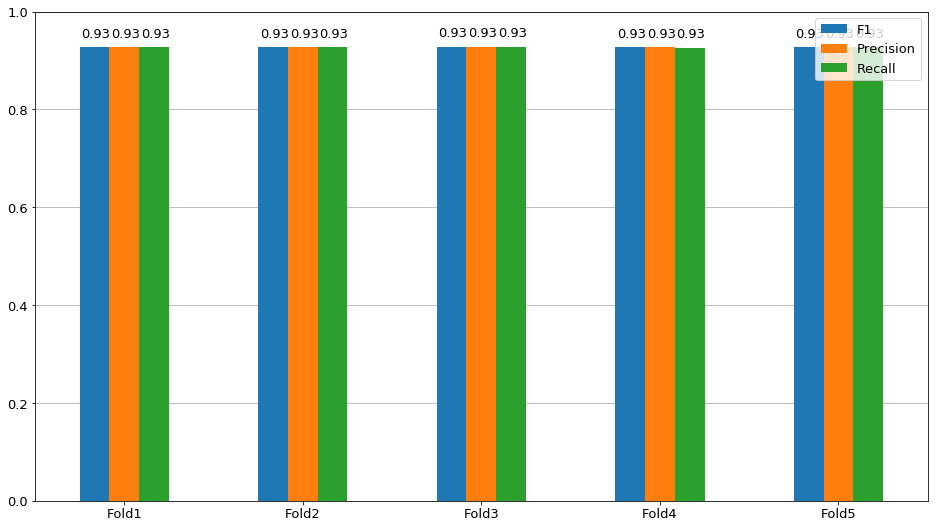

In [30]:
df_MNB_scores = pd.DataFrame(data=MNB_scores)
df_MNB_scores.columns = ['F1', 'Precision', 'Recall']
df_MNB_scores.index = ['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5']
p = df_MNB_scores.plot.bar(figsize=(16,9), ylim=(0,1))
plt.xticks(rotation='horizontal')
p.axes.yaxis.grid()
p.set_axisbelow(True)
for i in p.patches:
    # get_x pulls left or right; get_height pushes up or down
    p.text(i.get_x()+0.01, i.get_height()+0.02, str(round(i.get_height(), 2)))
f = p.get_figure()
f.savefig(output_path + 'MNB_CV_Scores.pdf')

In [31]:
df_MNB_summary = pd.DataFrame(data=np.matrix([
                            [f1_mean, precision_mean, recall_mean],
                            [f1_std, precision_std, recall_std]
                            ]).T,
                            index=['F1', 'Precison', 'Recall'],
                            columns=['Mean', 'STD'])
df_MNB_summary

,Mean,STD
F1,0.927400,0.000625
Precison,0.927453,0.000597
Recall,0.927350,0.000651


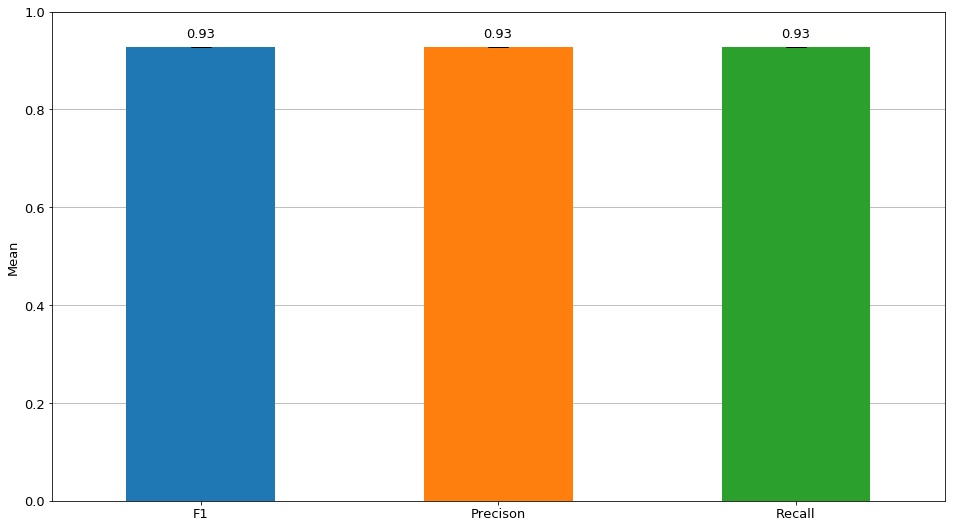

In [32]:
summary_plt = df_MNB_summary['Mean'].plot.bar(figsize=(16,9), yerr=df_MNB_summary['STD'], ylim=(0,1), capsize=10)
summary_plt.set_ylabel('Mean')
summary_plt.axes.yaxis.grid()
plt.xticks(rotation='horizontal')
summary_plt.set_axisbelow(True)
for i in summary_plt.patches:
    # get_x pulls left or right; get_height pushes up or down
    summary_plt.text(i.get_x()+0.2, i.get_height()+0.02, str(round(i.get_height(), 2)))
summary_plt.figure.savefig(output_path + 'Avg_MNB_scores.pdf')

# Save the trained model in a pickle file

In [33]:
joblib.dump(MNB, output_path + 'MNB_b_b.pkl')

['./Output/MNB_b_b.pkl']

In [34]:
MNB_pred = MNB.predict(X_test)
MNB_pred_prob = MNB.predict_proba(X_test)
print('Predictions: {}'.format(MNB_pred))
print('Predictions Probabilities: {}'.format(MNB_pred_prob.round(2)))

Predictions: [0. 1. 1. ... 1. 1. 1.]
Predictions Probabilities: [[0.75 0.25]
 [0.1  0.9 ]
 [0.   1.  ]
 ...
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]]


# Choose a range of probabilities where the model is confused

In [35]:
# Calculate the difference between the two prediction of a data point
diff = [abs(pred[0] - pred[1]) for pred in MNB_pred_prob]
diff_sr = pd.Series(diff)
diff_sr.describe()

count    848319.000000
mean          0.937401
std           0.174079
min           0.000020
25%           0.988871
50%           0.999879
75%           1.000000
max           1.000000
dtype: float64

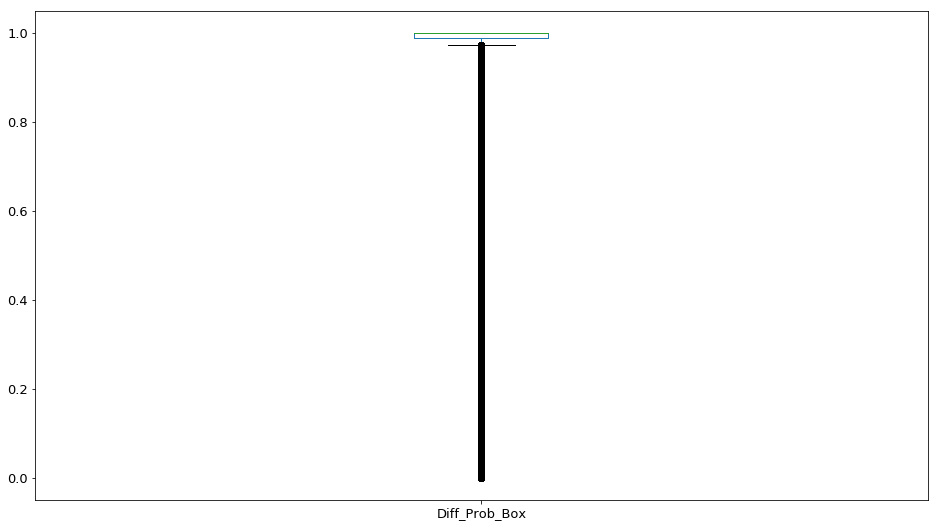

In [36]:
p = diff_sr.plot.box(figsize=(16,9), label='Diff_Prob_Box')
p.figure.savefig(output_path + 'Diff_Prob_Box.pdf')

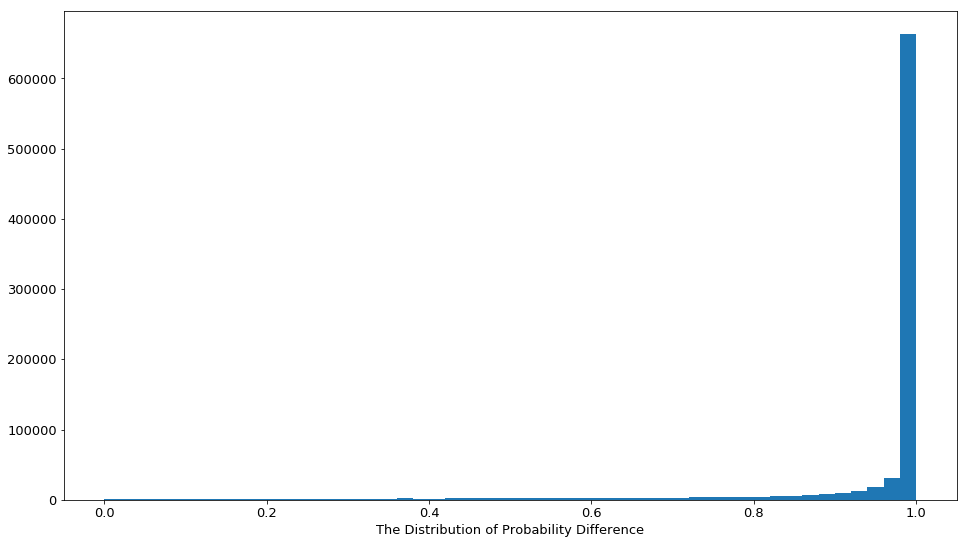

In [37]:
p = diff_sr.hist(bins=50, figsize=(16,9), grid=False)
p.set_xlabel('The Distribution of Probability Difference')
p.figure.savefig(output_path + 'Diff_Prob_Hist.pdf')

In [38]:
# If the difference between the p(0|x) and p(1|x) is smaller than 0.6 (it's enough as a threshold)
ix_ambig = [ix for ix in range(MNB_pred_prob.shape[0]) if abs(MNB_pred_prob[ix][0] - MNB_pred_prob[ix][1]) < 0.6]
print(len(ix_ambig))

51965


In [39]:
# Label all the ambiguous data points as 3-star
for ix in range(len(ix_ambig)):
    MNB_pred[ix_ambig[ix]] = 3

In [40]:
pd.Series(MNB_pred).value_counts()

1.0    596804
0.0    199550
3.0     51965
dtype: int64

In [41]:
joblib.dump(MNB_pred, output_path + 'Predictions.pkl')

['./Output/Predictions.pkl']

# MNB Results

In [42]:
MNB_accuracy = round(accuracy_score(y_test, MNB_pred), 2)
print('Model Accuracy: {}'.format(MNB_accuracy))
with open(output_path + 'Accuracy.txt', 'wb') as f:
    f.write(str(MNB_accuracy))

Model Accuracy: 0.79


In [43]:
MNB_CM = confusion_matrix(y_test, MNB_pred)
print('Confusion Matrix:\n{}'.format(MNB_CM))

Confusion Matrix:
[[141926  18244  15803]
 [ 21383 509769  20210]
 [ 36241  68791  15952]]


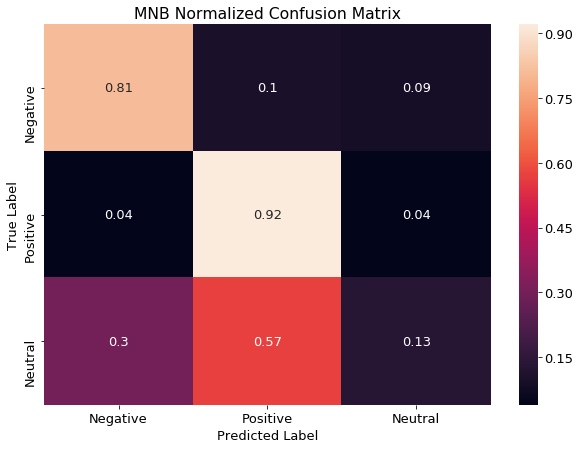

In [44]:
utils.cm_plot(MNB_CM, ['Negative', 'Positive', 'Neutral'], 'MNB Normalized Confusion Matrix', output_path + 'MNB_CM.pdf')

In [45]:
print(classification_report(y_test, MNB_pred))

             precision    recall  f1-score   support

        0.0       0.71      0.81      0.76    175973
        1.0       0.85      0.92      0.89    551362
        3.0       0.31      0.13      0.18    120984

avg / total       0.75      0.79      0.76    848319



# Compare MNB With The Random Classifer

In [46]:
pd.Series(y_test).value_counts()

1.0    551362
0.0    175973
3.0    120984
Name: stars, dtype: int64

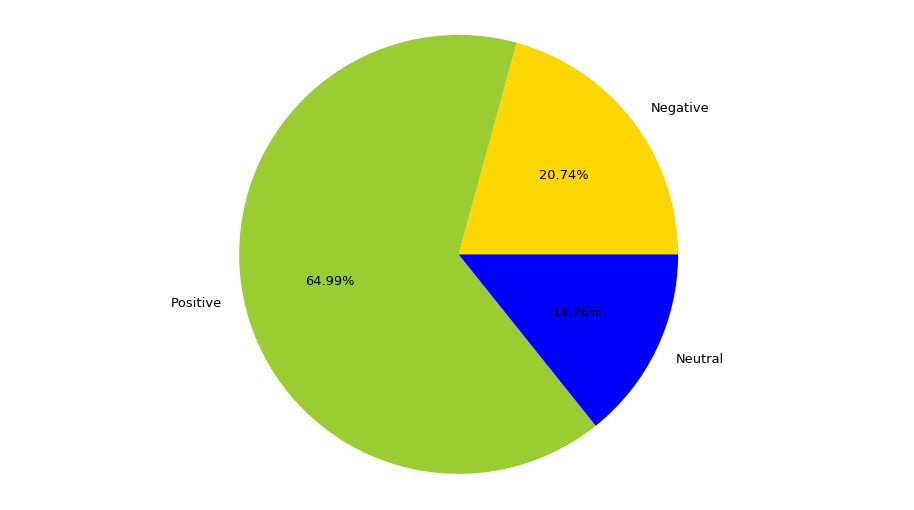

In [47]:
# Rating Distribution
values, counts = np.unique(y_test, return_counts=True)
colors = ['gold', 'yellowgreen', 'blue']

# Plot
mpl.rcParams['font.size'] = 13.0
f = plt.figure()
f.set_size_inches(16,9)
plt.pie(counts, labels=['Negative', 'Positive', 'Neutral'], colors=colors, autopct='%1.2f%%')
plt.axis('equal')
plt.show()
f.savefig(output_path + 'Random_Distribution.pdf')

In [48]:
random_pred = np.empty(y_test.shape[0])
random_pred.fill(pd.Series(y_test).value_counts().idxmax())
print('Predictions: {}'.format(random_pred))

Predictions: [1. 1. 1. ... 1. 1. 1.]


# Cohen's-Kappa

In [49]:
print(cohen_kappa_score(MNB_pred, random_pred))

0.0
